# Stock Price Forecasting Using ARIMAres
Arima model which means Auto Regressive Moving average uses past(lags) or previous values to predict future values. The values have to be Stationary. Stationary means


It is characterised by 3 terms:
* p:Is the order of auto regressive term
* d: is the number of differencing required to make the time series stationary
* q: is the order of the moving average term

In [1]:
#import Libraries
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
volks = yf.Ticker("VOW.DE")
volks

yfinance.Ticker object <VOW.DE>

In [3]:
#Get historical data
volks_data = volks.history(start ="2015-01-01", end=date.today(), interval="1d")
volks_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-05-21,272.000000,274.399994,270.799988,272.600006,50295,0.0,0
2021-05-25,275.399994,281.200012,274.600006,276.600006,93542,0.0,0
2021-05-26,278.200012,281.600006,275.000000,280.399994,54119,0.0,0
2021-05-27,280.200012,286.000000,276.000000,286.000000,195964,0.0,0
2021-05-28,288.200012,300.200012,287.000000,300.000000,169332,0.0,0


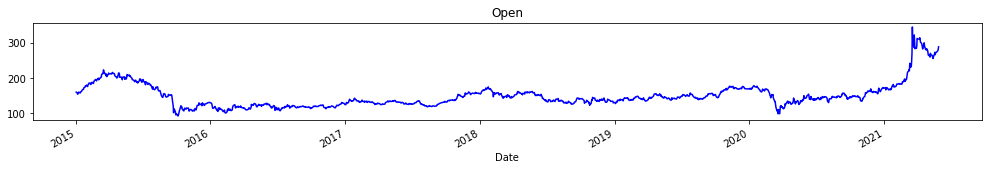

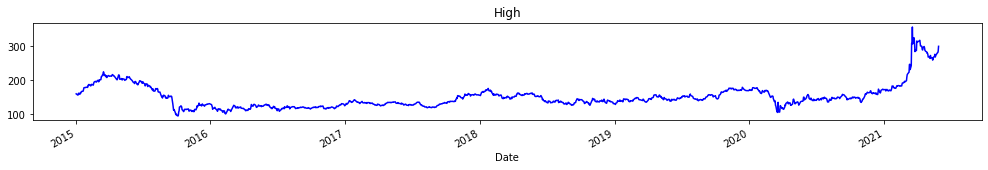

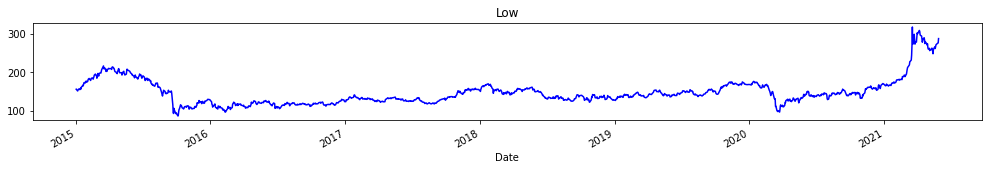

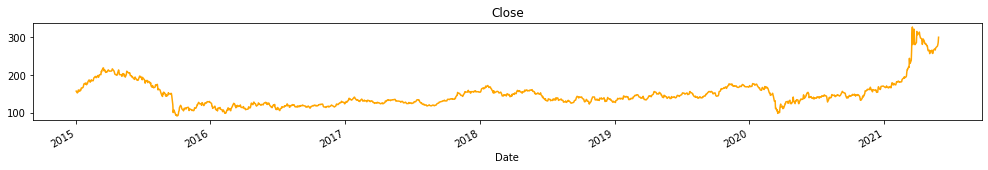

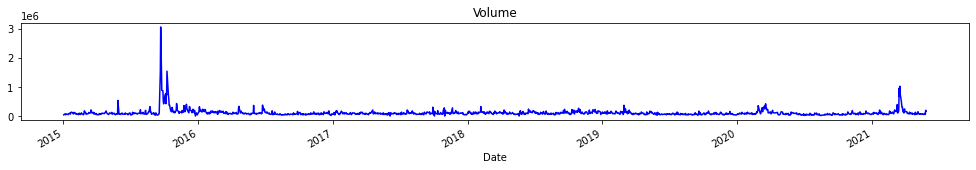

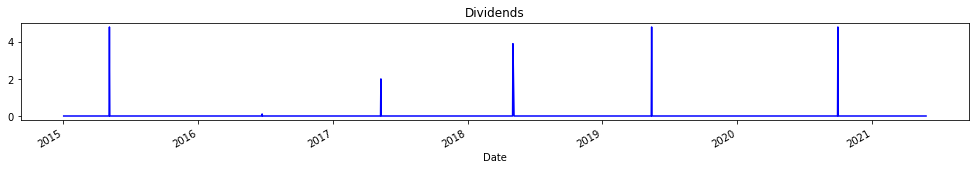

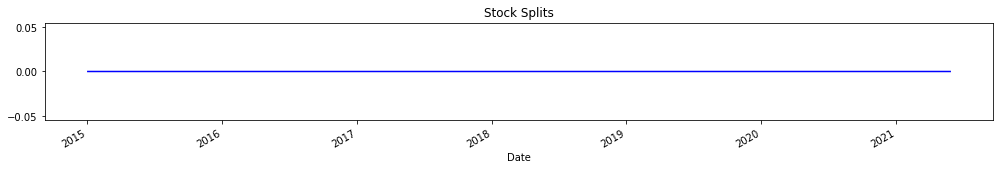

In [4]:
%matplotlib inline

for col in volks_data.columns:
    color="orange" if col == "Close" else "blue"
    volks_data[col].plot(figsize=(17, 2), color=color)
    plt.title(col)
    plt.show()

In [5]:
volks_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1623.000000,1623.000000,1623.000000,1623.000000,1.623000e+03,1623.000000,1623.0
mean,148.283710,150.150116,146.165324,148.146164,1.108631e+05,0.012575,0.0
std,34.447246,35.179544,33.625413,34.478214,1.400296e+05,0.233038,0.0
min,91.479473,94.097042,85.747904,91.298943,0.000000e+00,0.000000,0.0
25%,126.418280,128.111672,124.945392,126.273132,6.401150e+04,0.000000,0.0
50%,141.109375,142.657901,139.367285,141.012589,8.648000e+04,0.000000,0.0
75%,158.422308,160.103875,156.641168,158.724625,1.169680e+05,0.000000,0.0
max,344.600006,357.399994,317.200012,327.200012,3.058738e+06,4.800000,0.0


## Determining if the Time series is Stationary
We use Augumented dickey fuller Test to for test for stationarity
### ADF test
A Dickey-Fuller test is a unit root test that tests the null hypothesis that α=1 in the following model equation. alpha is the coefficient of the first lag on Y.

Null Hypothesis (H0): alpha=1



where,

* y(t-1) = lag 1 of time series
* delta Y(t-1) = first difference of the series at time (t-1)
Fundamentally, it has a similar null hypothesis as the unit root test. That is, the coefficient of Y(t-1) is 1, implying the presence of a unit root. If not rejected, the series is taken to be non-stationary.
If p-value < 0.05, we can reject the null hypothesis and infer that the time series is stationary.

In [6]:
#Drop columns to avoid multicoliinearity
df = volks_data[["Close"]].copy()
df.head()

,Close
Date,
2015-01-02,157.194336
2015-01-05,152.424179
2015-01-06,153.660873
2015-01-07,154.411743
2015-01-08,160.374435


In [7]:
#check for stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF statistic: {result[0]}")
print(f"p_value: {result[1]}")

ADF statistic: -0.22401858273329628
p_value: 0.935597450406793


### Autocorrelation Function(ACF)
Our p-value is greater than 0.05 that means we need to find the order of differencing.

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

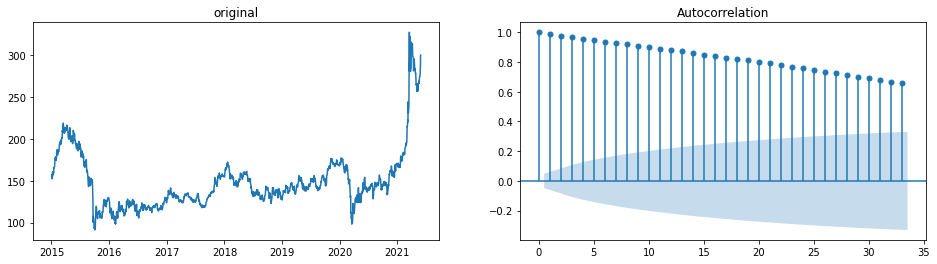

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("original") # ; is used to avoid duplicarton of plot
plot_acf(df.Close, ax=ax2);

### Getting the number of differencing(d)

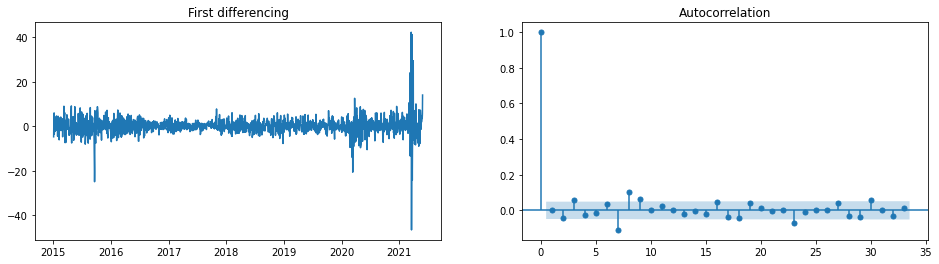

In [10]:
# differencing
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("First differencing")
plot_acf(diff, ax=ax2);

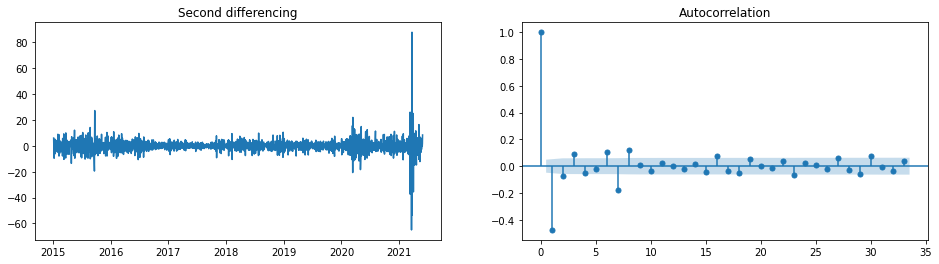

In [11]:
# Second differencing
diff = df.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Second differencing")
plot_acf(diff, ax=ax2);

#### Using pmdarima to find the number of differencing(d)

In [12]:
!pip install -- pmdarima

In [13]:
from  pmdarima.arima.utils import ndiffs
ndiffs(df.Close, test="adf")

1

##### P
p is the number of lags to be used as predictors. To determine it we will use the Partial Autocorrelation(pacf) plot

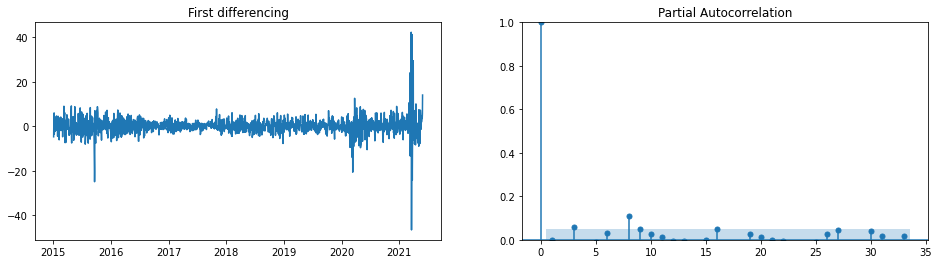

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
# differencing
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("First differencing")
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 3,8,9 are significant as they are above the significance line. We will choose 3.

##### q
q refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can use the ACF plot for the number of MA terms.

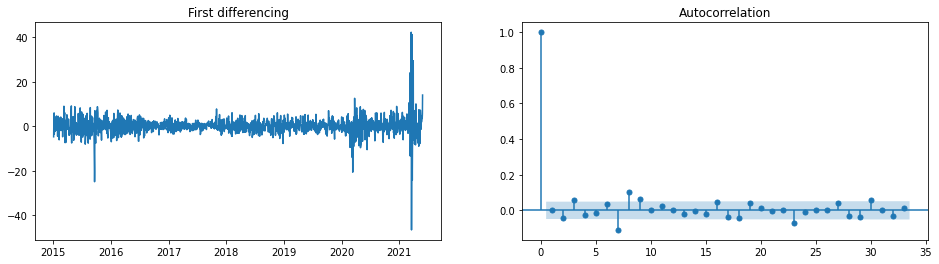

In [15]:
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("First differencing")
plot_acf(diff, ax=ax2);

We can choose 3 for our forecast error since it's a little bit above the significance line.

### Fitting the Model

In [35]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df.Close, order=(8,1,3))
result = model.fit(disp=1)
result.summary()

/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/sayo/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1622
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4439.735
Method:                       css-mle   S.D. of innovations              3.737
Date:                Sat, 29 May 2021   AIC                           8895.470
Time:                        16:56:19   BIC                           8938.602
Sample:                             1   HQIC                          8911.475
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0876      0.091      0.961      0.337      -0.091       0.266
ar.L1.D.Close    -2.2002      0.075    -29.264      0.000      -2.348      -2.053
ar.L2.D.Close    -2.0026      0.130    -15.357      0.000      -2.258      -1.747
ar.L3.D.Close    -0.7561      0.083     -9.107      0.000      -0.919      -0.593
ma.L1.D.Close     2.2037      0.081     27.322      0.000       2.046       2.362
ma.L2.D.Close     1.9538      0.139     14.084      0.000       1.682       2.226
ma.L3.D.Close     0.6961      0.088      7.890      0.000       0.523       0.869
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0935           -0.0000j            1.0935           -0.5000
AR.2           -0.7776           -0.7778j            1.0998           -0.3750
AR.3           -0.7776           +0.7778j            1.0998            0.3750
MA.1           -1.1305           -0.0000j            1.1305           -0.5000
MA.2           -0.8382           -0.7538j            1.1273           -0.3834
MA.3           -0.8382           +0.7538j            1.1273            0.3834
-----------------------------------------------------------------------------
"""

(array([7.17120860e-05, 0.00000000e+00, 2.86848344e-04, 7.17120860e-04,
        4.97681877e-02, 6.41106049e-02, 1.00396920e-03, 1.43424172e-04,
        7.17120860e-05, 1.43424172e-04]),
 array([-43.31126654, -34.71407121, -26.11687587, -17.51968054,
         -8.9224852 ,  -0.32528987,   8.27190547,  16.8691008 ,
         25.46629614,  34.06349147,  42.66068681]),
 <BarContainer object of 10 artists>)

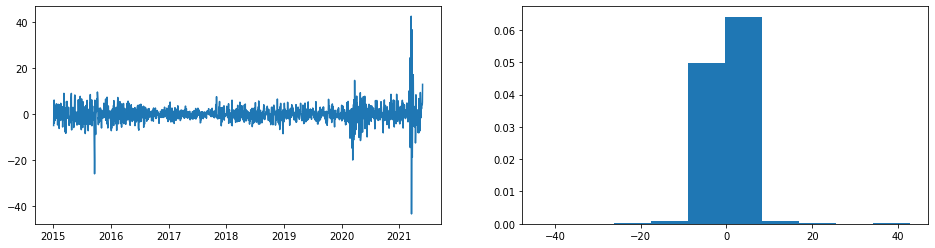

In [17]:
#plot the residuals
residuals = pd.DataFrame(result.resid)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

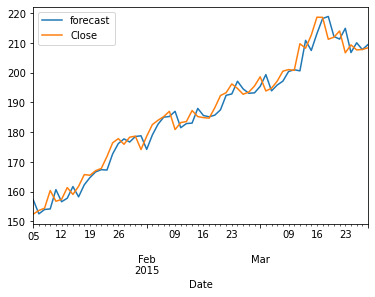

In [18]:
#Actual vs Fitted
result.plot_predict(start =1, end=60, dynamic=False, );

## Real Modelling and Forecast

In [26]:
data = df.reset_index()

In [27]:
data.tail()

,Date,Close
1618,2021-05-21,272.600006
1619,2021-05-25,276.600006
1620,2021-05-26,280.399994
1621,2021-05-27,286.000000
1622,2021-05-28,300.000000


In [28]:
data = data.drop(columns=["Date"])
data.head()

,Close
0,157.194336
1,152.424179
2,153.660873
3,154.411743
4,160.374435


### Splitting the Data

In [29]:
index= int(len(data) * 0.8)
train = data.Close[:index]
test = data.Close[index:]

In [30]:
print(len(train))
print(len(test))

1298
325


### Fit the Model

In [36]:
model = ARIMA(train, order=(3,1,3))
result = model.fit(disp=0)

In [37]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1297
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -3069.893
Method:                       css-mle   S.D. of innovations              2.577
Date:                Sat, 29 May 2021   AIC                           6155.786
Time:                        16:57:08   BIC                           6197.129
Sample:                             1   HQIC                          6171.300
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0077      0.078      0.099      0.921      -0.145       0.160
ar.L1.D.Close     0.5748      0.167      3.434      0.001       0.247       0.903
ar.L2.D.Close    -0.5758      0.166     -3.462      0.001      -0.902      -0.250
ar.L3.D.Close    -0.4076      0.166     -2.459      0.014      -0.733      -0.083
ma.L1.D.Close    -0.4699      0.157     -2.995      0.003      -0.777      -0.162
ma.L2.D.Close     0.4835      0.156      3.104      0.002       0.178       0.789
ma.L3.D.Close     0.5212      0.157      3.319      0.001       0.213       0.829
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5019           -0.8737j            1.0076           -0.1670
AR.2            0.5019           +0.8737j            1.0076            0.1670
AR.3           -2.4162           -0.0000j            2.4162           -0.5000
MA.1            0.4955           -0.8686j            1.0000           -0.1675
MA.2            0.4955           +0.8686j            1.0000            0.1675
MA.3           -1.9188           -0.0000j            1.9188           -0.5000
-----------------------------------------------------------------------------
"""

In [38]:
#fc: forecast, conf: confidence interval, se:standard error
step = 30
fc, se, conf = result.forecast(step)

In [39]:
conf

array([[162.7073446 , 172.80796421],
       [160.35591241, 175.40793166],
       [158.51581029, 177.06265296],
       [156.98989252, 178.64933007],
       [155.67177358, 180.02948387],
       [154.52655926, 181.27262861],
       [153.47204821, 182.34462947],
       [152.4615893 , 183.30515651],
       [151.48640239, 184.22334318],
       [150.57185681, 185.1484366 ],
       [149.73446292, 186.06675608],
       [148.95774811, 186.92883579],
       [148.20320633, 187.70323688],
       [147.44649166, 188.41091575],
       [146.69764374, 189.10703643],
       [145.98613025, 189.83007186],
       [145.32762797, 190.56723405],
       [144.70572712, 191.27089486],
       [144.08713288, 191.90818386],
       [143.45470277, 192.49390805],
       [142.82306531, 193.07629745],
       [142.22163283, 193.6903848 ],
       [141.66358106, 194.32479466],
       [141.13157073, 194.93517139],
       [140.59471589, 195.48963399],
       [140.03962812, 196.00028333],
       [139.48293564, 196.51104023],
 

In [42]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

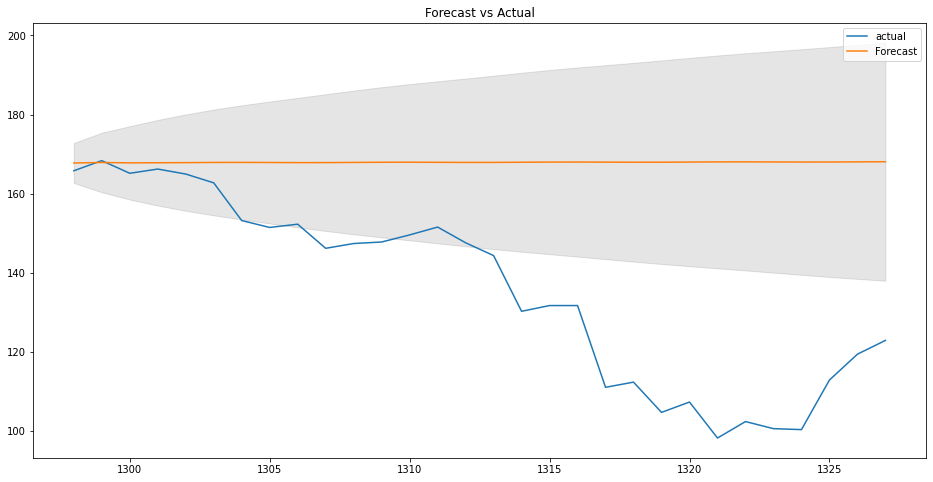

In [43]:
plt.figure(figsize=(16,8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="Forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper right")

## Conclusion
ARIMA model does not really work in the real work because the Price Markets are much
too complicated to be modelled by simple leinear regression.